In [33]:
# import libary
import tensorflow as tf
tf.set_random_seed(6789)
import numpy as np
import matplotlib.pyplot as plt
import sys 

In [26]:
N=100000
sig2=0.2
x=np.sign(np.random.normal(0.,1.,[N,1]))
y=x+np.random.normal(0.,np.sqrt(sig2),[N,1])
p_y_x=np.exp(-(y-x)**2/(2*sig2))
p_y_x_minus=np.exp(-(y+1)**2/(2*sig2))
p_y_x_plus=np.exp(-(y-1)**2/(2*sig2))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
print(mi)

0.6592202048562272


In [17]:
x = tf.placeholder(tf.float32, [None,1])
y = tf.placeholder(tf.float32, [None,1])
y_ = tf.placeholder(tf.float32, [None,1])
 
n_hidden=10
 
Wx=tf.Variable(tf.random_normal(stddev=0.1,shape=[1,n_hidden]))
Wy=tf.Variable(tf.random_normal(stddev=0.1,shape=[1,n_hidden]))
b=tf.Variable(tf.constant(0.1,shape=[n_hidden]))
 
hidden_joint=tf.nn.relu(tf.matmul(x,Wx)+tf.matmul(y,Wy)+b)
hidden_marg=tf.nn.relu(tf.matmul(x,Wx)+tf.matmul(y_,Wy)+b)
 
Wout=tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden,1]))
bout=tf.Variable(tf.constant(0.1,shape=[1]))
 
out_joint=tf.matmul(hidden_joint,Wout)+bout
out_marg=tf.matmul(hidden_marg,Wout)+bout
 
lower_bound=tf.reduce_mean(out_joint)-tf.log(tf.reduce_mean(tf.exp(out_marg)))
 
train_step = tf.train.AdamOptimizer(0.005).minimize(-lower_bound)

values = []
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(1000):
    x_sample=np.sign(np.random.normal(0.,1.,[N,1]))#np.random.normal(0.,1.,[N,1])
    y_sample=x_sample+np.random.normal(0.,np.sqrt(sig2),[N,1])
    y_shuffle=np.random.permutation(y_sample)
    number,_ = sess.run([lower_bound,train_step], feed_dict={x:x_sample,y:y_sample,y_:y_shuffle})
    values.append(number)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [18]:
print(len(values))

1000


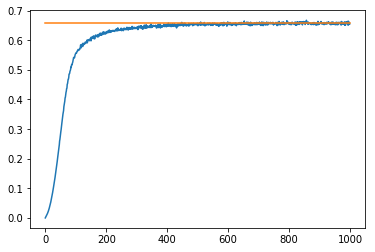

In [27]:
plt.plot(values)
plt.plot(np.ones_like(values)*mi)
plt.show()

In [37]:
# with two guassian
N=100000
sig1 = 0.2
sig2 = 0.3
mi = 0.5 * np.log(1+sig1/ sig2)
print(mi)

0.25541281188299536


In [79]:
def det(array_or_scalar):
    if array_or_scalar.size > 1:
        return np.linalg.det(array_or_scalar)
    else:
        return array_or_scalar
def get_h_mvn(x):

    """
    Computes the entropy of a multivariate Gaussian distribution:
    H(X) = (1/2) * log((2 * pi * e)^d * det(cov(X)))
    Arguments:
    ----------
    x: (n, d) ndarray
        n samples from a d-dimensional multivariate normal distribution
    Returns:
    --------
    h: float
        entropy H(X)
    """

    d = x.shape[1]
    h  = 0.5 * np.log((2 * np.pi * np.e)**d * det(np.cov(x.T)))
    return h
def get_mi_mvn(x, y):
    """
    Computes the mutual information I between two multivariate normal random
    variables, X and Y:
    I(X, Y) = H(X) + H(Y) - H(X, Y)
    Arguments:
    ----------
    x, y: (n, d) ndarrays
        n samples from d-dimensional multivariate normal distributions
    Returns:
    --------
    mi: float
        mutual information I(X, Y)
    """

    d = x.shape[1]

    # hx  = 0.5 * log((2 * np.pi * np.e)**d     * det(np.cov(x.T)))
    # hy  = 0.5 * log((2 * np.pi * np.e)**d     * det(np.cov(y.T)))
    # hxy = 0.5 * log((2 * np.pi * np.e)**(2*d) * det(np.cov(x.T, y=y.T)))
    # mi = hx + hy - hxy

    # hx  = 0.5 * log(det(2*np.pi*np.e*np.cov(x.T)))
    # hy  = 0.5 * log(det(2*np.pi*np.e*np.cov(y.T)))
    # hxy = 0.5 * log(det(2*np.pi*np.e*np.cov(np.c_[x,y].T)))
    hx  = get_h_mvn(x)
    hy  = get_h_mvn(y)
    hxy = get_h_mvn(np.c_[x,y])
    mi = hx + hy - hxy

    # mi = 0.5 * (log(det(np.cov(x.T))) + log(det(np.cov(y.T))) - log(det(np.cov(np.c_[x,y].T))))

    return mi

N=10000
sig1 = 1.
dependent = 0.99
mean  =  [0,0]
sigma = np.array([
    [1,dependent],
    [dependent,1]
])
temp  = np.random.multivariate_normal(mean,sigma,10000)
x_sample = temp[:,0][:,None]
y_sample = temp[:,1][:,None]
mi = get_mi_mvn(x_sample,y_sample)
print(mi)
print(x_sample.shape)

1.952636521277309
(10000, 1)


In [80]:
x = tf.placeholder(tf.float32, [None,1])
y = tf.placeholder(tf.float32, [None,1])
y_ = tf.placeholder(tf.float32, [None,1])
 
n_hidden=10
 
Wx=tf.Variable(tf.random_normal(stddev=0.1,shape=[1,n_hidden]))
Wy=tf.Variable(tf.random_normal(stddev=0.1,shape=[1,n_hidden]))
b=tf.Variable(tf.constant(0.1,shape=[n_hidden]))
 
hidden_joint=tf.nn.relu(tf.matmul(x,Wx)+tf.matmul(y,Wy)+b)
hidden_marg=tf.nn.relu(tf.matmul(x,Wx)+tf.matmul(y_,Wy)+b)
 
Wout=tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden,1]))
bout=tf.Variable(tf.constant(0.1,shape=[1]))
 
out_joint=tf.matmul(hidden_joint,Wout)+bout
out_marg=tf.matmul(hidden_marg,Wout)+bout
 
lower_bound=tf.reduce_mean(out_joint)-tf.log(tf.reduce_mean(tf.exp(out_marg)))
 
train_step = tf.train.AdamOptimizer(0.005).minimize(-lower_bound)

values = []
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(1000):
    #x_sample  = np.random.normal(0.,sig1,[N,1])
    #y_sample  = np.random.normal(0.,sig2,[N,1])
    y_shuffle = np.random.permutation(y_sample)
    number,_  = sess.run([lower_bound,train_step], feed_dict={x:x_sample,y:y_sample,y_:y_shuffle})
    sys.stdout.write("\r" + str(number))
    sys.stdout.flush()
    values.append(number)

1.89322315517

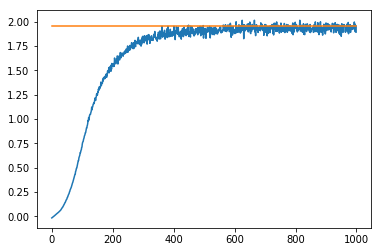

In [81]:
plt.plot(values)
plt.plot(np.ones_like(values)*mi)
plt.show()

In [104]:
def det(array_or_scalar):
    if array_or_scalar.size > 1:
        return np.linalg.det(array_or_scalar)
    else:
        return array_or_scalar
def get_h_mvn(x):

    """
    Computes the entropy of a multivariate Gaussian distribution:
    H(X) = (1/2) * log((2 * pi * e)^d * det(cov(X)))
    Arguments:
    ----------
    x: (n, d) ndarray
        n samples from a d-dimensional multivariate normal distribution
    Returns:
    --------
    h: float
        entropy H(X)
    """

    d = x.shape[1]
    h  = 0.5 * np.log((2 * np.pi * np.e)**d * det(np.cov(x.T)))
    return h
def get_mi_mvn(x, y):
    """
    Computes the mutual information I between two multivariate normal random
    variables, X and Y:
    I(X, Y) = H(X) + H(Y) - H(X, Y)
    Arguments:
    ----------
    x, y: (n, d) ndarrays
        n samples from d-dimensional multivariate normal distributions
    Returns:
    --------
    mi: float
        mutual information I(X, Y)
    """

    d = x.shape[1]

    # hx  = 0.5 * log((2 * np.pi * np.e)**d     * det(np.cov(x.T)))
    # hy  = 0.5 * log((2 * np.pi * np.e)**d     * det(np.cov(y.T)))
    # hxy = 0.5 * log((2 * np.pi * np.e)**(2*d) * det(np.cov(x.T, y=y.T)))
    # mi = hx + hy - hxy

    # hx  = 0.5 * log(det(2*np.pi*np.e*np.cov(x.T)))
    # hy  = 0.5 * log(det(2*np.pi*np.e*np.cov(y.T)))
    # hxy = 0.5 * log(det(2*np.pi*np.e*np.cov(np.c_[x,y].T)))
    hx  = get_h_mvn(x)
    hy  = get_h_mvn(y)
    hxy = get_h_mvn(np.c_[x,y])
    mi = hx + hy - hxy

    # mi = 0.5 * (log(det(np.cov(x.T))) + log(det(np.cov(y.T))) - log(det(np.cov(np.c_[x,y].T))))

    return mi

N=900000
dimension = 140
mean  = np.zeros(dimension)
# sigma = np.random.uniform(0.5,1,size=(dimension,dimension))
sigma = np.ones((dimension,dimension)) * 0.9
# sigma = (sigma + sigma.T)/2
# sigma = np.around(sigma,2)
np.fill_diagonal(sigma,1.0)

temp  = np.random.multivariate_normal(mean,sigma,10000)
x_sample = temp[:,:dimension//2]
print(x_sample.shape)
y_sample = temp[:,dimension//2:]
mi = get_mi_mvn(x_sample,y_sample)
print(temp.shape)
print(mi)

(10000, 70)
(10000, 140)
3.144787721547459


In [129]:
x = tf.placeholder(tf.float32, [None,dimension//2])
y = tf.placeholder(tf.float32, [None,dimension//2])
y_ = tf.placeholder(tf.float32, [None,dimension//2])
 
n_hidden=15
 
Wx=tf.Variable(tf.random_normal(stddev=0.05,shape=[dimension//2,n_hidden]))
Wy=tf.Variable(tf.random_normal(stddev=0.05,shape=[dimension//2,n_hidden]))
b=tf.Variable(tf.constant(0.0,shape=[n_hidden]))
 
hidden_joint=tf.nn.elu(tf.matmul(x,Wx)+tf.matmul(y,Wy)+b)
hidden_marg=tf.nn.elu(tf.matmul(x,Wx)+tf.matmul(y_,Wy)+b)
 
Wout=tf.Variable(tf.random_normal(stddev=0.05,shape=[n_hidden,1]))
bout=tf.Variable(tf.constant(0.0,shape=[1]))
 
out_joint=tf.matmul(hidden_joint,Wout)+bout
out_marg=tf.matmul(hidden_marg,Wout)+bout
 
lower_bound=tf.reduce_mean(out_joint)-tf.log(tf.reduce_mean(tf.exp(out_marg)))
 
train_step = tf.train.AdamOptimizer(0.05).minimize(-lower_bound)

values = []
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(1000):
    #x_sample  = np.random.normal(0.,sig1,[N,1])
    #y_sample  = np.random.normal(0.,sig2,[N,1])
    y_shuffle = np.random.permutation(y_sample)
    number,_  = sess.run([lower_bound,train_step], feed_dict={x:x_sample,y:y_sample,y_:y_shuffle})
    sys.stdout.write("\r" + str(number))
    sys.stdout.flush()
    values.append(number)

2.8306618951

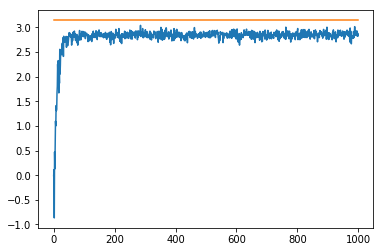

In [130]:
plt.plot(values)
plt.plot(np.ones_like(values)*mi)
plt.show()

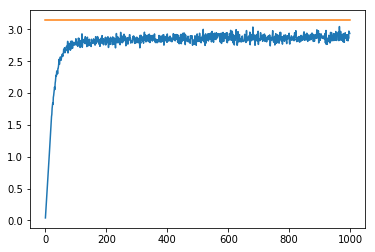

In [109]:
plt.plot(values)
plt.plot(np.ones_like(values)*mi)
plt.show()

In [106]:
! git all-go

[master adc16fc] commit
 2 files changed, 162 insertions(+), 48 deletions(-)
Counting objects: 4, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 769 bytes | 256.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/JaeDukSeo/Mututal-Information.git
   7e480f7..adc16fc  master -> master
